In [62]:
import os.path

import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import norm
import theano.tensor as tt

%matplotlib inline

So far this is just a AR1 process evaluation

https://docs.pymc.io/notebooks/AR.html

In [19]:
# skiprows=4, header=None, 
df = pd.read_csv('jgra20797-sup-0004-ds02.txt', delim_whitespace=True, error_bad_lines=False)
df.head()

,Date,E1-0.0241,E2-0.0317,E3-0.0416,E4-0.0625,E5-0.0900,E6-0.1275,E7-0.1725,E8-0.2700,E9-0.4075,E10-0.6250,E11-0.9250,E12-1.3000,E13-2.0000
0,1989-09-22,7.02088,6.91479,6.73989,6.29968,5.65105,4.73455,3.86499,3.42100,3.05657,2.38786,1.386500,0.081027,-2.41694
1,1989-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1989-09-25,6.18888,6.05347,5.84277,5.33594,4.62288,3.74056,3.27748,3.09556,2.80957,2.25364,1.392040,0.251700,-1.44719
4,1989-09-26,6.77264,6.60430,6.34967,5.74662,4.90194,3.79355,2.97890,2.59865,2.21483,1.58831,0.688826,-0.466389,-2.30885


In [27]:
df['Date'] = pd.DatetimeIndex(df['Date'])
df.index=df['Date']

In [28]:
df.head()

,Date,E1-0.0241,E2-0.0317,E3-0.0416,E4-0.0625,E5-0.0900,E6-0.1275,E7-0.1725,E8-0.2700,E9-0.4075,E10-0.6250,E11-0.9250,E12-1.3000,E13-2.0000
Date,,,,,,,,,,,,,,
1989-09-22,1989-09-22,7.02088,6.91479,6.73989,6.29968,5.65105,4.73455,3.86499,3.42100,3.05657,2.38786,1.386500,0.081027,-2.41694
1989-09-23,1989-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-09-24,1989-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-09-25,1989-09-25,6.18888,6.05347,5.84277,5.33594,4.62288,3.74056,3.27748,3.09556,2.80957,2.25364,1.392040,0.251700,-1.44719
1989-09-26,1989-09-26,6.77264,6.60430,6.34967,5.74662,4.90194,3.79355,2.97890,2.59865,2.21483,1.58831,0.688826,-0.466389,-2.30885


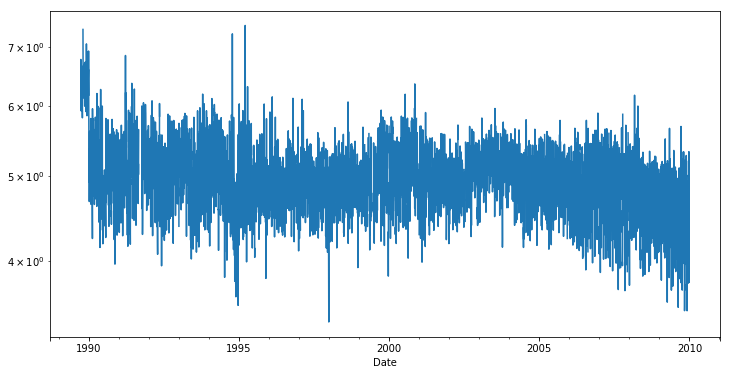

In [30]:
df['E1-0.0241'].plot(logy=True, figsize=(12,6))

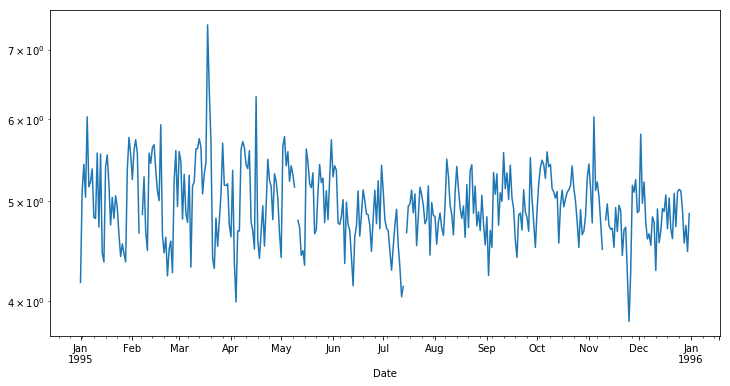

In [31]:
df2 = df['E1-0.0241'].loc['1995']
df2.plot(logy=True, figsize=(12,6))

In [34]:
df2.head()

Date
1995-01-01    4.17046
1995-01-02    5.11424
1995-01-03    5.42572
1995-01-04    5.04142
1995-01-05    6.03041
Name: E1-0.0241, dtype: float64

# Build a pymc3 model

In [54]:
tau=1.0
y = df2.dropna().values
with pm.Model() as armodel:
    beta = pm.Normal('beta', mu=0, sd=tau)
    data = pm.AR('y', beta, sd=1.0, observed=y)
    trace = pm.sample(5000, cores=4, tune=1500)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 26000/26000 [00:05<00:00, 4842.66draws/s]


/Users/balarsen/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


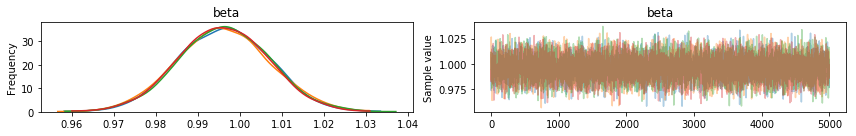

In [55]:
pm.traceplot(trace);

In [56]:
mup = ((y[:-1]**2).sum() + tau**-2)**-1 * np.dot(y[:-1],y[1:])
Vp =  ((y[:-1]**2).sum() + tau**-2)**-1
print('Mean: {:5.3f} (exact = {:5.3f})'.format(trace['beta'].mean(), mup))
print('Std: {:5.3f} (exact = {:5.3f})'.format(trace['beta'].std(), np.sqrt(Vp)))


Mean: 0.996 (exact = 0.996)
Std: 0.011 (exact = 0.011)


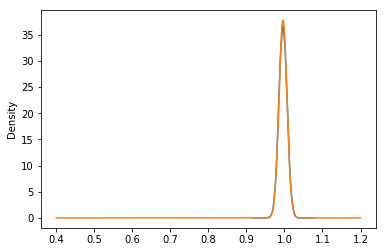

In [57]:

ax=pd.Series(trace['beta']).plot(kind='kde')
xgrid = np.linspace(0.4, 1.2, 1000)
fgrid = norm(loc=mup, scale=np.sqrt(Vp)).pdf(xgrid)
ax.plot(xgrid,fgrid);

## Try a bit fancier

In [63]:
def linear_regression(X, y):
    with pm.Model() as model:
        w = pm.Flat('w', shape=X.shape[1])
        σ = pm.HalfCauchy('σ', beta=10.)
        y_obs = pm.Normal('y', mu=tt.dot(X, w), sd=σ, observed=y.squeeze())
    return model

In [64]:
X = df2.dropna().index.to_julian_date()
with linear_regression(X, y):
    linear_trace = pm.sample(2000)

IndexError: tuple index out of range